# Unsupervised Topic Discovery

## Introduction
Unsupervised Topic Discovery is a task that aims to detect underlying general topics distribution over a collection of unlabelled text documents. Formally, let $y_{il}$ denote the $l^{th}$ word of $i^{th}$ document. and $i \in {1,2,...,N}$ and $l \in 1,2,...L$. The unsupervised topic discovery task is a subtask of building a language model that parameterized by latent topic distribution, that is, to learn a probability distribution, parameterized by a set of parameters $\theta$ that maximizes the joint probability of 

$$\prod_{i=1}^{N} p(y_i | q_i)p(q_i)$$.

We will see how the way we parameterized the language model can be interpreted as underlying topics.

## Data preprocessing

We need to convert raw text to [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix). That is to represent the entire corpus using a $N \times V$ matrix where $N$ is the number of document and $V$ is the magnitude of the vocabulary (vocabulary size). From now on we use $n_i$ to represents the count vector of docuemnt $i$. and $L_i$ to represents the total number of word count in document $i$.

One can easily do this with assorted python libraries. I usually use `sklearn.feature_extraction.text.CountVectorizer`.

Pretty often people use Tf-idf as representation. For the demo purpose we skip this.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
path_data = '../data/10000.csv'
df_data = pd.read_csv(path_data)
# Drop NA
df_data = df_data.dropna()

In [4]:
count_vectorizer = CountVectorizer(
    max_features=20000,
    stop_words='english',
    #strip_accents='ascii',
    token_pattern='[a-zA-Z]{2,}',
    max_df=0.8,
    min_df=2,
)

In [5]:
document_term_matrix = count_vectorizer.fit_transform(df_data['extracted_content'])

In [6]:
# The result is stored in a sparse matrix
document_term_matrix

<10000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 1878455 stored elements in Compressed Sparse Row format>

## Baseline Model: Multinomial mixture

### Model

Let's supposed we determined that there exits $K$ underlying topics in the corpus. One simple way to represents document $y_i$ is to use a $K$-dimensional simplex(probability) vector $q_i$. And use a $V$-dimension simplex vector $b_k$ to represent the word distribution of topic $k$. Let's use a [Multinoulli distribution](https://en.wikipedia.org/wiki/Categorical_distribution) for prior and use a [Multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) for likelihood:

\begin{align}
p(q_i=k) &= Cat(\pi_i)\\
p(y_{il}| b_k) &= Cat(y_{il} | b_k) \\
p(n_i | q_i=k, L_i, b_k) &= Mu(n_i |  L_i, b_k)
\end{align}

or we can model the joint-likelihhod using:

$$
p(y_i | q_i=k, b_k) = \prod_{l=1}^{L} Cat(y_{il} | b_k)
$$

### Learning

The objective for learning a mixture model is to maximize the likelihood. Usually the MLE estimation is learned using a [Expectation-Maximization(EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

### Implementation
Surprisingly scikit-learn does not have an implementation of Multinomial mixture model yet. But does provided a base mixture model estimator class. May be I can implement it sometime.

## Latent Dirichlet Allocation (LDA)

### Model
The LDA is nothing fancy but replacing the multinoulli priors for $p(q_i)$ and $p(b_k)$ and we have in our baseline with a flat [Dirichlet Distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) parameterized by $\alpha$ and $\beta$:

\begin{align}
p(q_i=k) &= Dir(\alpha 1_K) \\
p(b_k) &= Dir(\gamma 1_V)
\end{align}.

And use Multinoulli or Multinomial for likelihood.

There are many good properties that justifies the usage of a Dirichlet distribution as Prior, two of the most important are:

- Dirichlet distribution has a support (domain) of [0,1].
- Dirichlet distribution is conjugate to multinouli and multinomial distribution, which means that if your likelihood is moutinouli or multinomial, your posterior would still be Dirichlet.

### learning
Learning of LDA is usually done by using a [Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), a Batch or online [Variational Bayes Inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). If you are interested please read the chapter 27.3.4 to 27.3.7 of [Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf).

### Implementation
There is a [sklearn implementation of LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation). Here is a demostration using our event data.

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

In [20]:
model_lda = LatentDirichletAllocation(
    n_components=10,
    learning_method='batch',
    max_iter=20,
)

In [21]:
model_lda.fit(document_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [22]:
# Check some model evaluation
model_lda.perplexity(document_term_matrix)

4065.278215299743

In [39]:
model_lda.components_

array([[ 0.10000439,  0.10000269,  0.10000023, ...,  0.10000683,
         6.42311337,  0.10002845],
       [ 9.28478022, 25.32711404, 24.0999934 , ...,  0.10000168,
         0.10006117, 11.2936172 ],
       [ 0.10002668,  0.10000072,  0.10000178, ...,  0.10000824,
         0.1000003 ,  0.10000262],
       ...,
       [ 1.33231629,  0.10000613,  0.10000136, ..., 44.33640358,
        10.73614562,  0.10000631],
       [ 0.10007511,  0.10014693,  0.1       , ..., 11.86348934,
         0.10000952,  0.10000162],
       [40.08470332,  1.4599187 ,  0.10000058, ...,  0.10000458,
         0.1000388 ,  3.34221772]])

In [46]:
# The following function is adapted from
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def print_top_words(model, feature_names, n_top_words):
    word_dist = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(word_dist):
        message = "Topic #%d: " % topic_idx
        message += " ".join([f'{feature_names[i]} ({np.round(topic[i],4)})'
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [47]:
print_top_words(model_lda, count_vectorizer.get_feature_names(), 10)

Topic #0: make (0.0067) food (0.0059) like (0.0054) recipe (0.0048) use (0.0044) just (0.0042) new (0.0039) time (0.0037) add (0.0035) chicken (0.0031)
Topic #1: com (0.0051) new (0.0049) ammoland (0.0045) gun (0.0045) like (0.0038) just (0.0035) car (0.0034) rifle (0.0033) use (0.0033) ar (0.0031)
Topic #2: information (0.0274) use (0.018) data (0.0169) service (0.0155) publishing (0.0129) prime (0.012) services (0.0098) cookies (0.0079) materials (0.0078) agreement (0.0077)
Topic #3: city (0.0066) new (0.006) said (0.006) home (0.0054) area (0.0041) water (0.0038) year (0.0037) land (0.0035) property (0.0028) world (0.0028)
Topic #4: million (0.0109) year (0.0103) tax (0.009) score (0.0078) billion (0.0069) said (0.0069) income (0.0066) financial (0.0064) money (0.0063) rotten (0.0059)
Topic #5: just (0.0085) like (0.0085) people (0.0075) time (0.0069) said (0.0062) know (0.0053) don (0.0043) life (0.0042) years (0.0039) way (0.0039)
Topic #6: new (0.0078) season (0.0073) game (0.007

Possible interpretation:
- Topic 0: Food/Diet
- Topic 1: Gun/Car/Consumer's product
- Topic 2: Cookie Agreement
- Topic 4: Finance News
- Topic 6; Entertainment
- Topic 8: Politic News
- Topic 9: Health Related

## Gamma-Poisson (GaP) Model

### Model

If you choose a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) prior and a (Poisson)[https://en.wikipedia.org/wiki/Poisson_distribution] likelihood, we have a Gamma-Poisson Model:
\begin{align}
p(z) &= Ga(z | \alpha, \beta) \\
p(n_{iv} | z) &= Poi(B_v^T z ) \\
\end{align}.

The reason to choose Poisson is that we might not always have the total count $L_i$ available. The reason of choosing a Gamma distribution is because that Gamma has a support of (0, $\inf$) and thus a weighted sum of $z_k$ can map to any positive parameter of Poisson Distribution.

### Learning

One drawback of the model is that the Gamma prior is not conjungate to Poisson likelihood. Usually the learning of a GaP model is done by using Variational Bayes Inference. If we choose $\alpha=\beta=1$, then $p(z)=1$. The learning of the model is reduced to a **Non-Negative Matrix Factorization** problem.

### Implementation

I haven't find any out-of-pocket implementation of GaP. May be one can build such model using package like PyMC3. 

Sklearn does have an implementation of NMF:

In [7]:
from sklearn.decomposition import NMF

In [8]:
model_nmf = NMF(
    n_components=10, 
    max_iter=20,
)

In [9]:
model_nmf.fit(document_term_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=20,
  n_components=10, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [48]:
print_top_words(model_nmf, count_vectorizer.get_feature_names(), 10)

Topic #0: information (0.0613) use (0.0289) services (0.0269) data (0.0163) cookies (0.0156) advertising (0.0142) user (0.0137) opt (0.0119) based (0.0117) technologies (0.0112)
Topic #1: just (0.0087) like (0.0076) time (0.007) know (0.0048) day (0.0048) got (0.0046) didn (0.0044) people (0.0043) don (0.0041) said (0.0041)
Topic #2: fullscreen (0.0681) com (0.0665) cartoonist (0.0623) homepage (0.0623) opinion (0.0491) journal (0.0287) news (0.0276) charlie (0.0177) daniel (0.0177) fla (0.0164)
Topic #3: google (0.0381) scholar (0.0353) pubmed (0.0165) crossref (0.0093) article (0.0089) al (0.0065) et (0.0065) cas (0.0051) patients (0.0042) fig (0.0041)
Topic #4: rear (0.0094) power (0.0075) features (0.0067) interior (0.0063) seats (0.0063) steering (0.0058) vehicle (0.0058) wheel (0.0057) control (0.0049) exterior (0.0048)
Topic #5: prime (0.0324) publishing (0.0315) materials (0.0238) agreement (0.0225) service (0.0179) affiliates (0.0147) images (0.0134) rights (0.0116) submit (0.

Possible interpretation:
- Topic 0: Cookie Agreement
- Topic 3: Health/ Research Paper
- Topic 6: Politic News
- Topic 7: Cookie Agreement
- Topic 8: Entertainment

## Correlated Topic Model

### Model

This model is proposed by the Blei and Jefferey at 2007. For more information please read:

Blei, D. M., & Lafferty, J. D. (2007). [A correlated topic model of science](https://projecteuclid.org/download/pdfview_1/euclid.aoas/1183143727). The Annals of Applied Statistics, 1(1), 17-35.



The general idea is that. We can extend LDA by allowing the prior $p(\pi)$ to learn its own covariance rather than assuming it to be independent. For example, instead of Dirichlet distribution, we can use a logistic normal distribution:

\begin{align}
p(z_i) &= \mathcal{N}(\mu, \Sigma) \\
p(\pi_i | z_i) &= S(z_i)
\end{align}

and use the same likelihood.

This model enables the learning of correlated topic (model topic cooccurrence).

### Implementation
A C implemenation: http://www.cs.columbia.edu/~blei/ctm-c/

#### Data input prepare
Under the CTM, the words of each document are assumed exchangeable.
Thus, each document is succinctly represented as a sparse vector of
word counts. The data is a file where each line is of the form:

     [M] [term_1]:[count_1] [term_2]:[count_2] ...  [term_N]:[count_3]

* [M] is the number of unique terms in the document

* [term_i] is an integer associated with the i-th term in the
  vocabulary.

* [count_i] is how many times the i-th term appeared in the document.

In [10]:
# Preparing the data for C program
def prepare_CTM_data(document_term_matrix):
    N, V = document_term_matrix.shape
    list_output_row = [f'{row.nnz} '+' '.join([f'{word_idx}:{count_idx}' for (_, word_idx), count_idx in row.todok().items()]) for row in document_term_matrix]
    return list_output_row

In [11]:
CTM_data = prepare_CTM_data(document_term_matrix)

In [76]:
output_CTM_data_filepath = '../data/ctm_data_input.txt'
with open(output_CTM_data_filepath, 'w') as f:
    f.write('\n'.join(CTM_data))
    f.close()

### Printing result topics

In [36]:
# Store a vocab.dat file for topic printing
vocab_dat_filepath = '../data/vocab.dat'
with open(vocab_dat_filepath, 'w') as f:
    f.write('\n'.join(count_vectorizer.get_feature_names()))
    f.close()

In [37]:
def print_topics(beta_file, vocab_file, nwords = 25,):
    vocab = open(vocab_file, 'r').read().split('\n')
    indices = np.array(list(range(len(vocab))))
    topic = np.array(list(map(float, open(beta_file, 'r').readlines())))
    nterms  = len(vocab)
    ntopics = int(len(topic)/nterms)
    topic   = np.reshape(topic, [ntopics, nterms])
    output = []
    for i in range(ntopics):
        word_dist = topic[i]
        top_n_word_idx = word_dist.argsort()[::-1][:nwords]
        print(f'Topic {i}: ', ' '.join([vocab[i] for i in top_n_word_idx]))
        output.append('\n'.join([vocab[i] for i in top_n_word_idx]))
    return output

In [40]:
beta_file_path = '../models/ctm/random-english-content/final-log-beta.dat'
vocab_file_path = '../models/ctm/random-english-content/vocab.dat'
topic_words = print_topics(beta_file_path, vocab_file_path, 7)

Topic 0:  software new data network technology security use
Topic 1:  price chart time stock month data market
Topic 2:  team year new season game photo state
Topic 3:  company business year million said market new
Topic 4:  said trump president people police state government
Topic 5:  com people information free search site phone
Topic 6:  prime publishing service agreement materials affiliates rights
Topic 7:  property aarp sale vehicle receive auction home
Topic 8:  home city room area house park hotel
Topic 9:  food make like recipe just use water
Topic 10:  like just time people said don know
Topic 11:  power energy earth light space damage level
Topic 12:  th score film credit tie rotten tomatoes
Topic 13:  google scholar pubmed crossref al et article
Topic 14:  car new gun like just read ammoland
Topic 15:  using water used fig data species different
Topic 16:  words open pages book document amazon science
Topic 17:  data information use service update cookies services
Topic 18:

#### Topic Graph estimation using lasso regression
The idea is estimating the adjacency matrix that encodes the conditional independence(CI) relations in Multivariate Normal distribution by fitting multiple lasso regressions. The detail is in:

Meinshausen, N., & Bühlmann, P. (2006). [High-dimensional graphs and variable selection with the lasso](https://projecteuclid.org/download/pdfview_1/euclid.aos/1152540754). The annals of statistics, 34(3), 1436-1462.

In [34]:
path_final_lambda = '../models/ctm/random-english-content/final-lambda.dat'
K = 20
x_var_mean = np.loadtxt(path_final_lambda).reshape(-1, K)

In [28]:
#TEST
import pickle as pkl
path_final_lambda = '../data/var_mean.pkl'
K = 20
x_var_mean = pkl.load(open(path_final_lambda,"rb")).reshape(-1, K)
topic_words = pkl.load(open('../data/topic_words.pkl',"rb"))


Parameters:
N=20000, K=20, lambda=0.3

Fitting...
Fitting completed!


/Users/jr/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(array([[ True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False],
        [False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, 

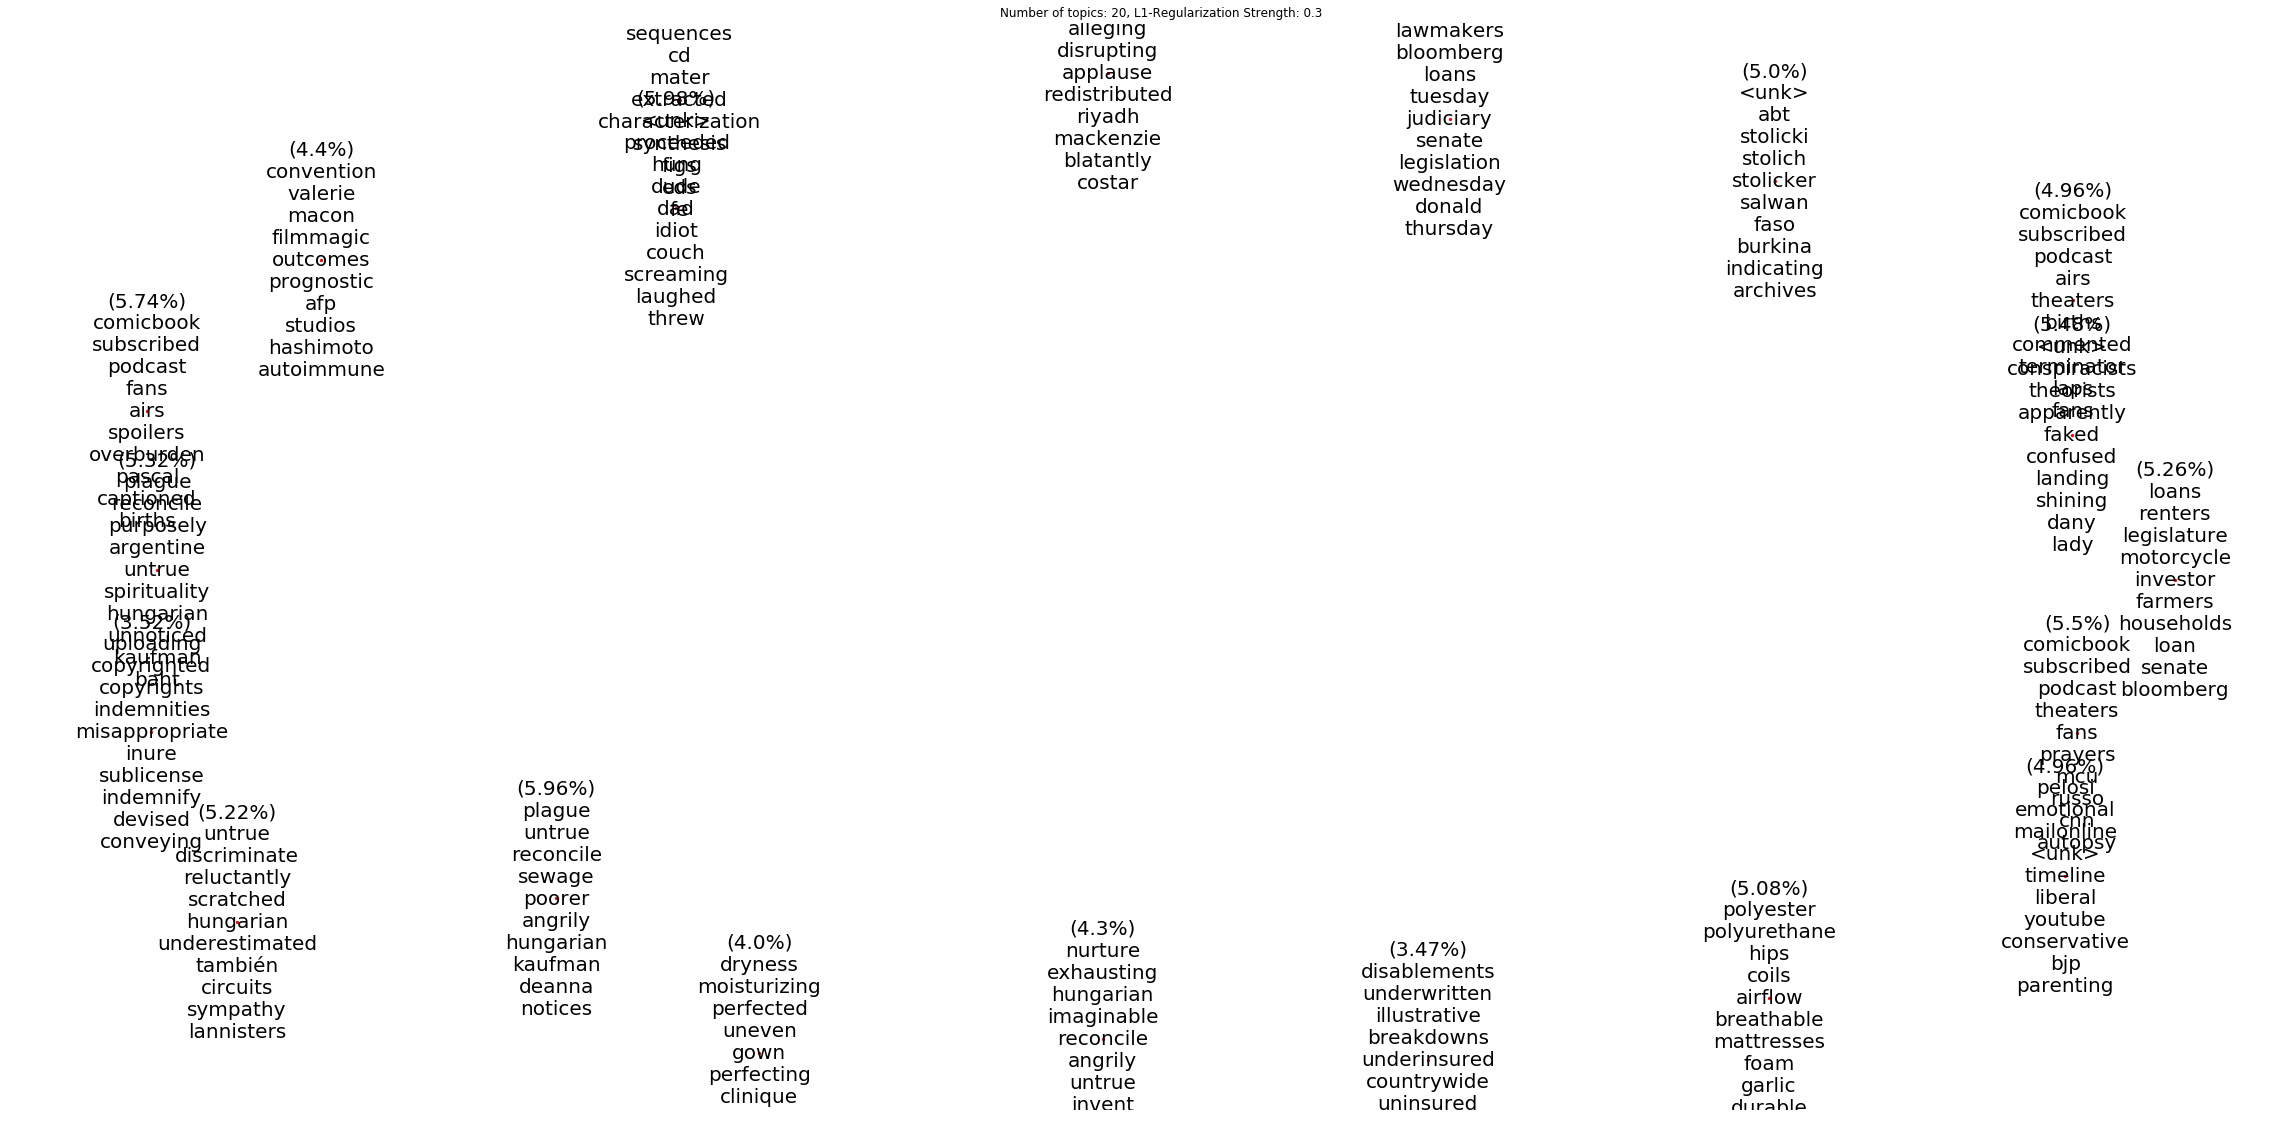

In [29]:
build_lasso_graph(x_var_mean,3e-1,topic_words)

from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import networkx as nx
from collections import Counter

def build_lasso_graph(x, l1_lambda, topic_words,both=True,):
    """
    A adaption from CTM's lasso-graph.r script
    
    Parameters
    ----------
    x: numpy.array
        N x K data matrix -- e.g., the variational means ("final-lambda.dat")
    l1_lambda: float
        relative bound on the l1-norm of the parameters, in [0,1]
    and: bool
        if and=T/F then the graph is computed by taking the intersction/union of the nbhds
        
    Returns
    -------
    ihat: numpy.array 
        K x K adjacency matrix of the topic graph
    """
    x = scale(x)
    topic_count = Counter(x.argmax(axis=1))
    N, K = x.shape
    Shat = np.zeros((K,K), dtype=bool)
    print('Parameters:')
    print(f'N={N}, K={K}, lambda={l1_lambda}')
    print()
    print('Fitting...')
    for j in range(K):
        column_mask = np.ones(K, dtype=bool)
        column_mask[j] = False
        # The response is the j-th column
        y = x[:,j]
        X = x[:,column_mask]
        # Do the l1-regularized regression
        # Note: the bound in l1ce code is the upper bound on the l1
        # norm.  So, a larger bound is a weaker constraint on the model
        lasso_model = Lasso(
            normalize=False,
            alpha=l1_lambda,
            tol=1e-6,
            #positive=True,
            max_iter=10000,
        )
        lasso_model.fit(X, y)
        indices = np.array(range(K))[column_mask]
        beta = lasso_model.coef_
        nonzero = indices[beta>0]
        Shat[j, nonzero] = True
        Shat[j,j] = True
    print('Fitting completed!')
    # Include an edge if either (and=F) or both (and=T) endpoints are neighbors
    Ihat = np.zeros((K,K), dtype=bool)
    if both is True:
        for i in range(K):
            Ihat[:, i] = Shat[:,i]&Shat[i,:]
    else:
        for i in range(K):
            Ihat[:, i] = Shat[:,i]|Shat[i,:]
    # Visualize topic graph
    # Construct Graph from adjacency matrix
    G = nx.from_numpy_array(Ihat)
    annotations = [f'({np.round(topic_count[i]*100/N, 2)}%)\n'+'\n'.join(topic_word) for i, topic_word in enumerate(topic_words)]
    node_label_dict = dict(zip(range(20), annotations))
    pos = nx.spring_layout(G, k=0.3)
    fig = plt.figure(figsize=(40,20))
    plt.title(f'Number of topics: {K}, L1-Regularization Strength: {l1_lambda}')
    nx.draw(G, pos, font_size=20, with_labels=True, labels=node_label_dict, node_size=5)
    return Ihat, fig

Parameters:
N=655954, K=20, lambda=0.3

Fitting...


/home/zlin/.conda/envs/topic_discovery/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/home/zlin/.conda/envs/topic_discovery/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Fitting completed!


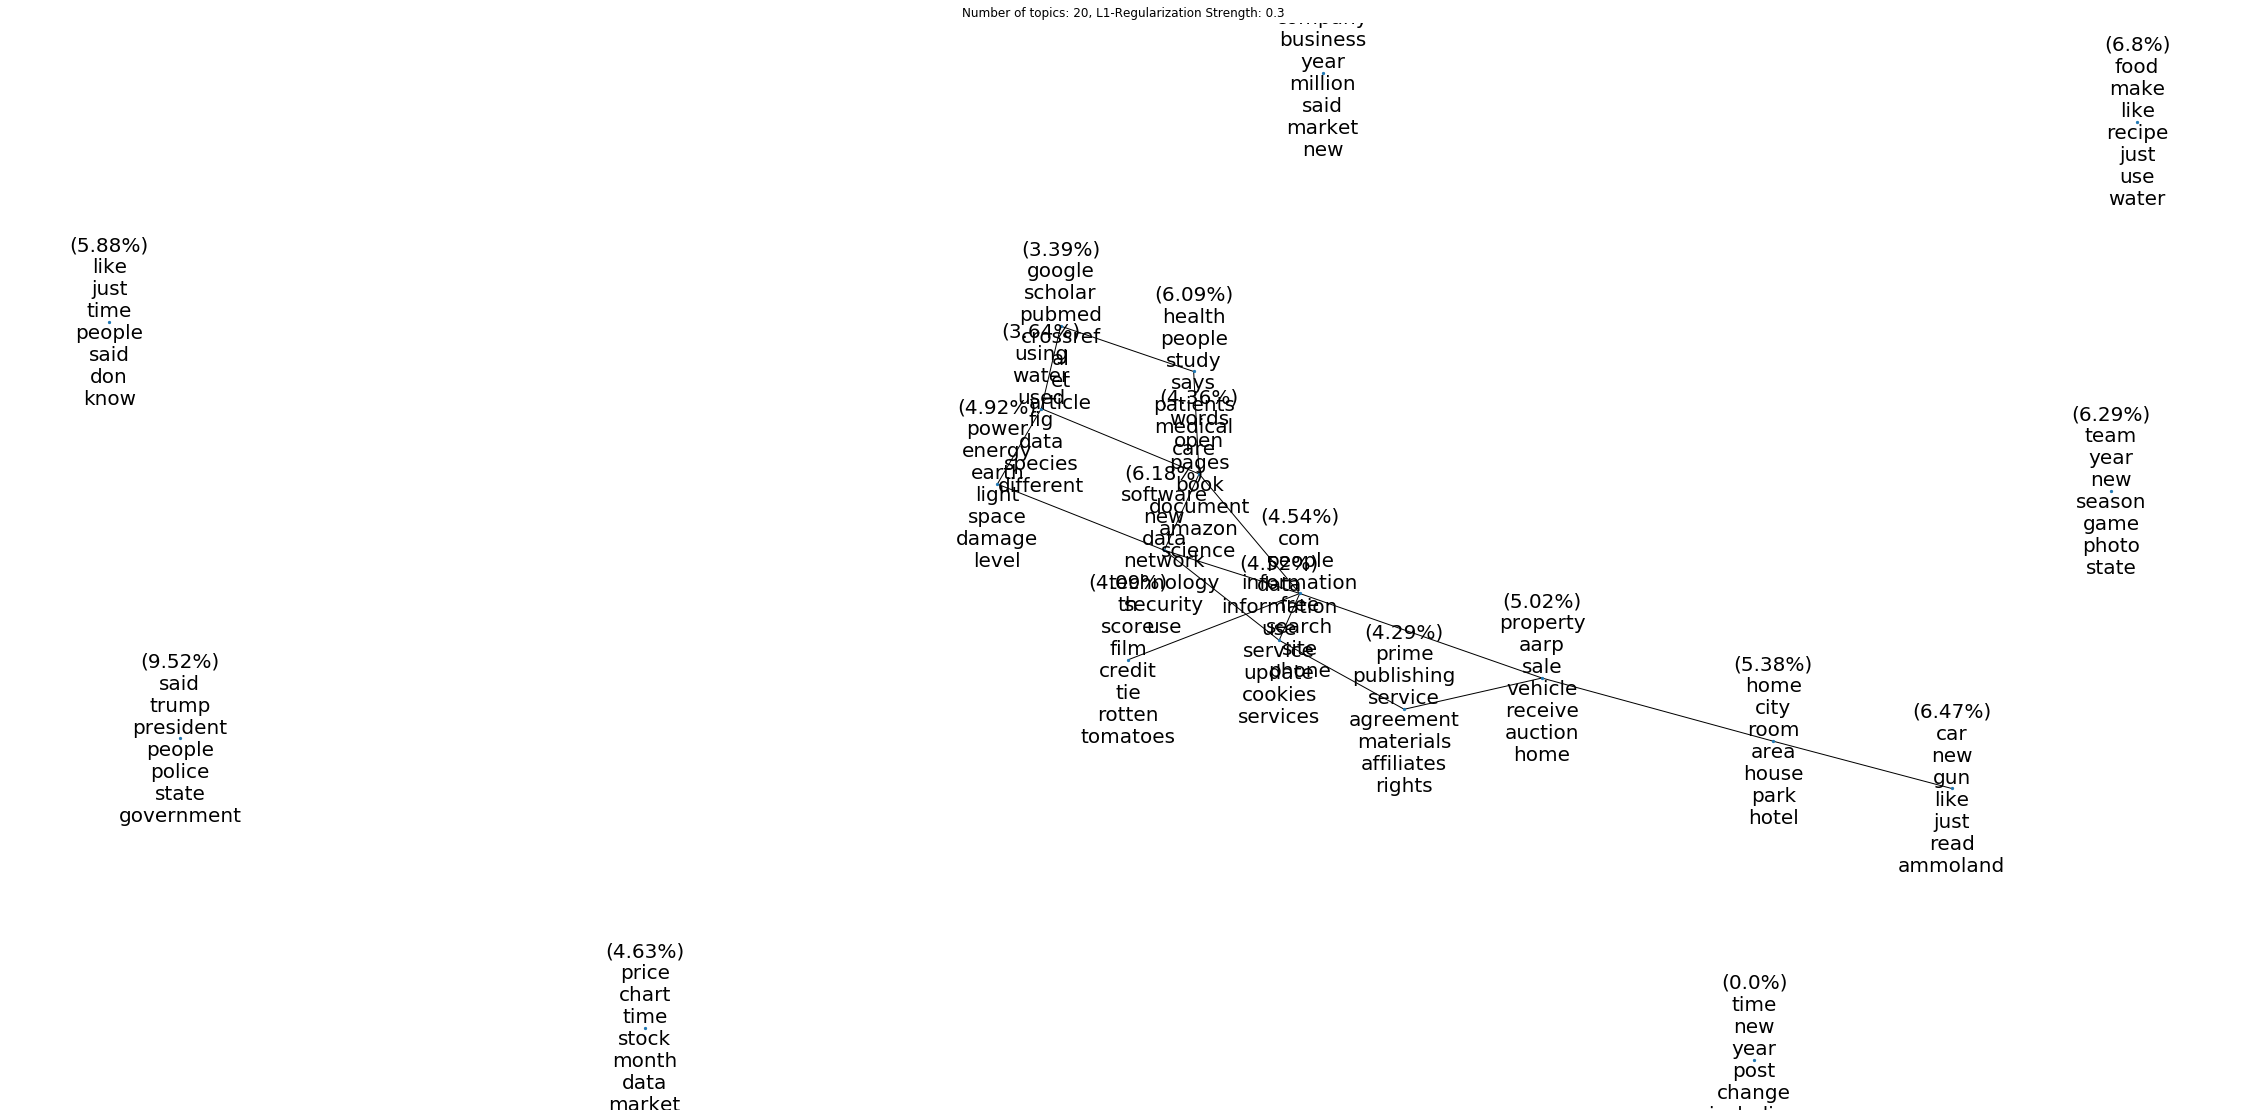

In [48]:
%matplotlib inline
topic_graph_adj_matrix, topic_graph_fig = build_lasso_graph(x_var_mean, 3e-1, topic_words, both=True)

In [32]:
topic_graph_fig.savefig('example_topic_graph.png')

## A little Deeper: CTM + word embeddings

Instead of fitting the document-term matrix, can we take the advantage of dense representations of word? Of course, such an intuitive idea has been published by some guys:

He, J., Hu, Z., Berg-Kirkpatrick, T., Huang, Y., & Xing, E. P. (2017, August). [Efficient correlated topic modeling with topic embedding](https://arxiv.org/pdf/1707.00206.pdf). In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 225-233). ACM.
